In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

In [2]:
class MultiArmBandit:
    """
    This class is what our agents will interact with.
    In __init__:
    - It instantiates the arms' reward distributions (bernouilli distributions with different means)
    - It sets the step counter to 0
    - It initialises the reward, action, regret lists
    In pull_arm:
    - It increments the step counter
    - It samples the reward from the arm's reward distribution
    - It calculates the regret
    - It returns the reward
    """
    def __init__(self, k):
        self.n_arms = k
        self.step = 0
        self.reward_list = []
        self.action_list = []
        self.regret_list = []
        self.arms_means = np.clip(np.random.normal(loc=0., scale=0.1, size=self.n_arms), 0, 0.8)

    def pull_arm(self, arm):
        self.step += 1
        reward = np.random.binomial(n=1, p=self.arms_means[arm])
        regret = np.max(self.arms_means) - self.arms_means[arm]
        self.reward_list.append(reward)
        self.action_list.append(arm)
        self.regret_list.append(regret)
        return reward
    
    def reset(self):
        self.step = 0
        self.reward_list = []
        self.action_list = []
        self.regret_list = []

In [3]:
class BanditAgent:
    def select_arm(self):
        raise NotImplementedError
    def update(self, arm, reward):
        raise NotImplementedError

class RandomAgent(BanditAgent):
    # This agent chooses a random arm at each step
    def __init__(self, n_arms):
        self.n_arms = n_arms
    def select_arm(self):
        return np.random.randint(0, self.n_arms)
    def update(self, arm, reward):
        pass
    
class QAgent(BanditAgent):
    def __init__(self, n_arms):
        self.q_values = np.zeros(n_arms)
        self.n_selections = np.zeros(n_arms)
    def select_arm(self):
        raise NotImplementedError
    def update(self, arm, reward):
        raise NotImplementedError

class GreedyQAgent(QAgent):
    # This agent estimates the average reward of each arm (q-value)
    # and selects the arm with the highest q-value at each step
    def select_arm(self):
        return np.argmax(self.q_values)
    def update(self, arm, reward):
        self.n_selections[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.n_selections[arm]

class EpsilonGreedyQAgent(QAgent):
    # This agent selects a random arm with probability epsilon
    # and selects the arm with the highest q-value with probability 1 - epsilon
    def __init__(self, n_arms, epsilon=0.1):
        super().__init__(n_arms)
        self.epsilon = epsilon
    def select_arm(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(0, len(self.q_values))
        else:
            return np.argmax(self.q_values)
    def update(self, arm, reward):
        self.q_values[arm] = reward

class UCBAgent(QAgent):
    # This agent selects the arm with the highest Upper Confidence Bound (UCB)
    # The UCB is the sum of the q-value and a term that increases with the total 
    # number of steps and decreases with the number of times the arm has been selected
    def __init__(self, n_arms, c=1.):
        super().__init__(n_arms)
        self.c = c
    def select_arm(self):
        if 0 in self.n_selections:
            return np.argmin(self.n_selections)
        ucb_values = self.q_values + self.c * np.sqrt(np.log(np.sum(self.n_selections)) / (self.n_selections))
        return np.argmax(ucb_values)
    def update(self, arm, reward):
        self.n_selections[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.n_selections[arm]

class ThompsonSamplingAgent(BanditAgent):
    # This agent uses Thompson Sampling to select the arm at each step
    # It samples the reward distribution of each arm and selects the arm with the highest sample
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)
    def select_arm(self):
        return np.argmax(np.random.beta(self.alpha, self.beta))
    def update(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

In [4]:
def show_results(logs, bandit, n_episodes, ep_len, agents):
    # plot reward distributions
    fig, ax = plt.subplots(1, 1, figsize=(35, 5))
    ax.set_title('Reward distributions')
    ax.set_xticks(np.arange(1, bandit.n_arms + 1))
    ax.set_xticklabels(np.arange(1, bandit.n_arms + 1))
    ax.bar(np.arange(1, bandit.n_arms + 1), bandit.arms_means)
    ax.set_xlabel('Arm')
    ax.set_ylabel('Mean reward')
    ax.set_ylim(0, 1)

    # plot algorithm performance
    fig, ax = plt.subplots(1, 4, figsize=(35, 5))


    all_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    agent_colors = {agent_name: color for agent_name, color in zip(agents.keys(), all_colors)}

    for agent_name, agent_logs in logs.items():
        for i, metric in enumerate(agent_logs.keys()):
            color = agent_colors[agent_name]
            mean = np.mean(agent_logs[metric], axis=0)
            ste = np.std(agent_logs[metric], axis=0) / np.sqrt(n_episodes)
            
            ax[i].plot(mean, label=agent_name, color=color)
            ax[i].set_xlabel('Timestep')
            ax[i].set_title(metric)
            if agent_name in ['EpsilonGreedy', 'UCB']:
                ax[i].fill_between(range(ep_len), mean - ste, mean + ste, alpha=0.5, color=color)
        
    ax[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Algorithm comparison

Running Random


100%|██████████| 100/100 [00:01<00:00, 67.08it/s]


Running EpsilonGreedy


100%|██████████| 100/100 [00:01<00:00, 58.95it/s]


Running UCB(0.1)


100%|██████████| 100/100 [00:03<00:00, 29.18it/s]


Running ThompsonSampling


100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


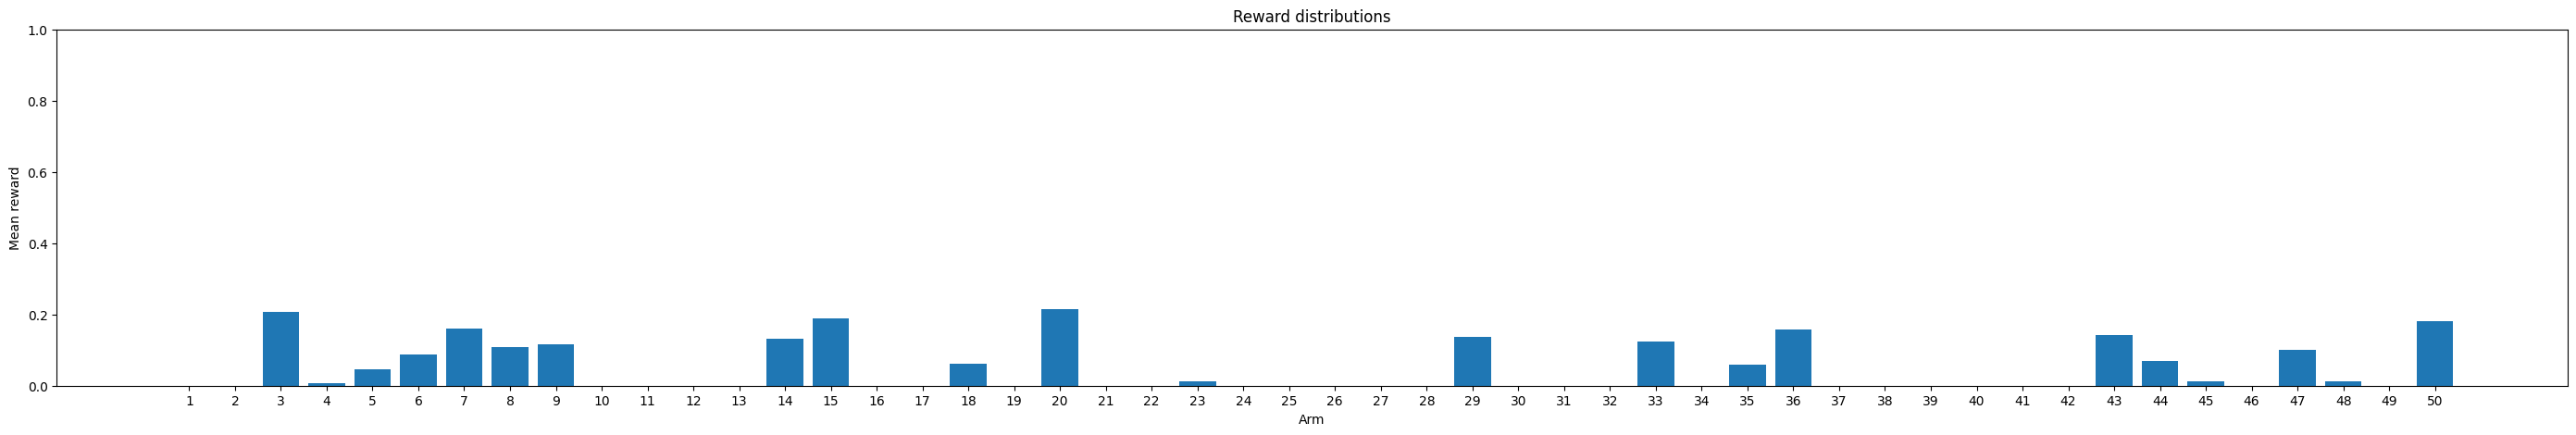

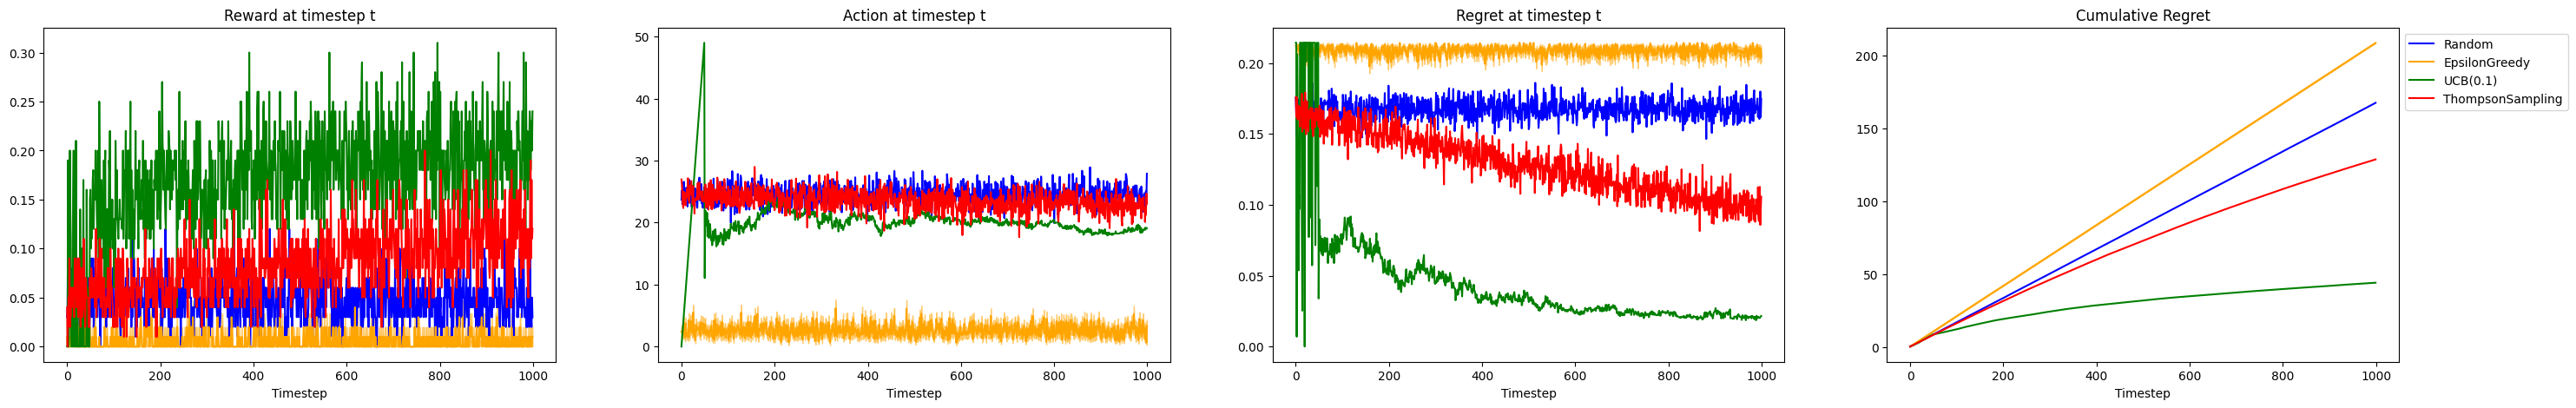

In [5]:
k = 50
n_episodes = 100
ep_len = 1000
bandit = MultiArmBandit(k)

agents = {
    'Random': RandomAgent,
    'EpsilonGreedy': EpsilonGreedyQAgent,
    'UCB(0.1)': lambda n_arms: UCBAgent(n_arms, c=0.1),
    'ThompsonSampling': ThompsonSamplingAgent,
}

logs = {
    agent_name: {
        'Reward at timestep t': [],
        'Action at timestep t': [],
        'Regret at timestep t': [],
        'Cumulative Regret': [],
    } for agent_name in agents.keys()
}

for agent_name, Algo in agents.items():
    print(f'Running {agent_name}')
    for _ in tqdm(range(n_episodes)):
        agent = Algo(bandit.n_arms)
        for _ in range(ep_len):
            arm = agent.select_arm()
            reward = bandit.pull_arm(arm)
            agent.update(arm, reward)
        logs[agent_name]['Reward at timestep t'].append(deepcopy(bandit.reward_list))
        logs[agent_name]['Action at timestep t'].append(deepcopy(bandit.action_list))
        logs[agent_name]['Regret at timestep t'].append(deepcopy(bandit.regret_list))
        logs[agent_name]['Cumulative Regret'].append(np.cumsum(bandit.regret_list))
        bandit.reset()

show_results(logs, bandit, n_episodes, ep_len, agents)

# Appendix

### Hyperparam search for UCB(c)

Running Random


100%|██████████| 100/100 [00:01<00:00, 67.13it/s]


Running UCB-0.


100%|██████████| 100/100 [00:03<00:00, 28.65it/s]


Running UCB-0.1


100%|██████████| 100/100 [00:03<00:00, 28.86it/s]


Running UCB-1.


100%|██████████| 100/100 [00:03<00:00, 29.28it/s]


Running UCB-10.


100%|██████████| 100/100 [00:03<00:00, 29.40it/s]


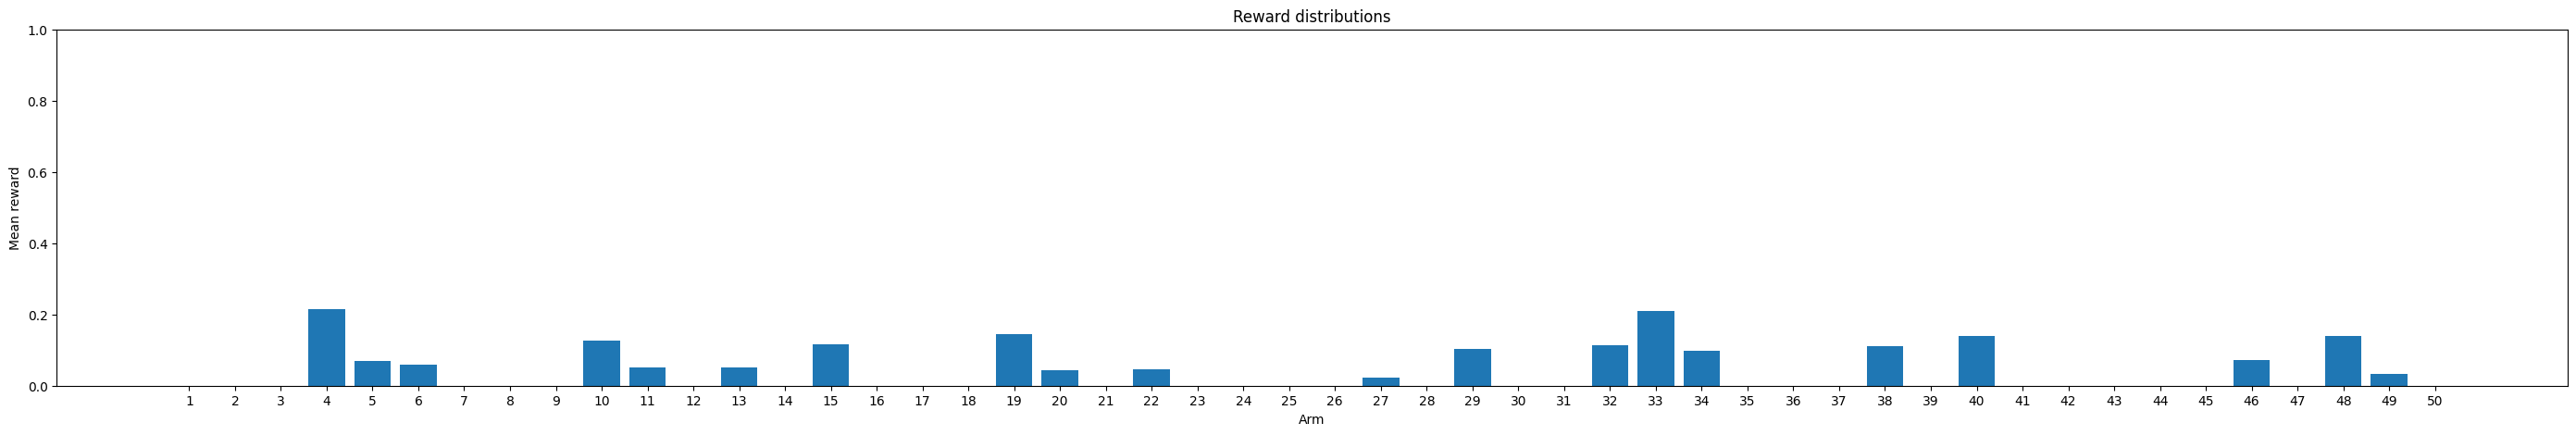

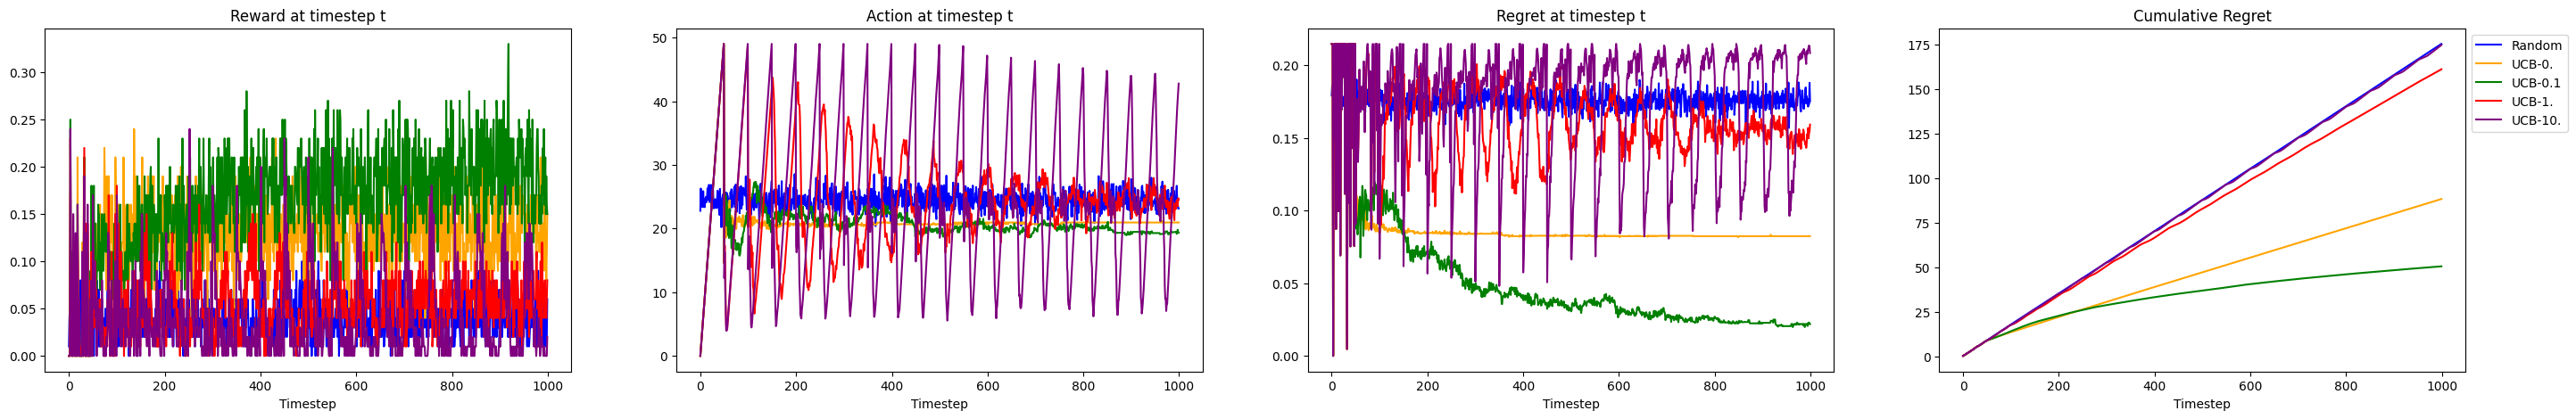

In [6]:
k = 50
n_episodes = 100
ep_len = 1000
bandit = MultiArmBandit(k)

agents = {
    'Random': RandomAgent,
    'UCB-0.': lambda n_arms: UCBAgent(n_arms, c=0.),
    'UCB-0.1': lambda n_arms: UCBAgent(n_arms, c=0.1),
    'UCB-1.': lambda n_arms: UCBAgent(n_arms, c=1.),
    'UCB-10.': lambda n_arms: UCBAgent(n_arms, c=10.),
}

logs = {
    agent_name: {
        'Reward at timestep t': [],
        'Action at timestep t': [],
        'Regret at timestep t': [],
        'Cumulative Regret': [],
    } for agent_name in agents.keys()
}

for agent_name, Algo in agents.items():
    print(f'Running {agent_name}')
    for _ in tqdm(range(n_episodes)):
        agent = Algo(bandit.n_arms)
        for _ in range(ep_len):
            arm = agent.select_arm()
            reward = bandit.pull_arm(arm)
            agent.update(arm, reward)
        logs[agent_name]['Reward at timestep t'].append(deepcopy(bandit.reward_list))
        logs[agent_name]['Action at timestep t'].append(deepcopy(bandit.action_list))
        logs[agent_name]['Regret at timestep t'].append(deepcopy(bandit.regret_list))
        logs[agent_name]['Cumulative Regret'].append(np.cumsum(bandit.regret_list))
        bandit.reset()

show_results(logs, bandit, n_episodes, ep_len, agents)

# Questions

- How to apply UCB in a non-binary setting? e.g. to Normally distributed rewards?
- How to implement Information-Directed Sampling (IDS) here?